![](../img/330-banner.png)

# Lecture 16: More Clustering 

UBC 2024-25

<br><br>

## Lecture plan and learning outcomes 

### Imports 

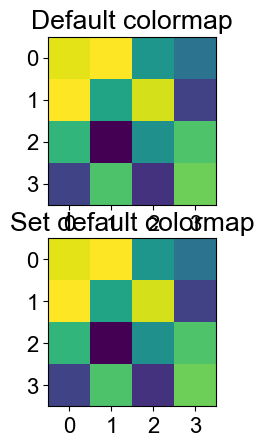

In [1]:
import os
import random
import sys

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
import matplotlib.pyplot as plt
import seaborn as sns
from plotting_functions import *
from plotting_functions_unsup import *
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn import cluster, datasets, metrics
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs, make_moons
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer

plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (5, 4)
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br>

### Learning outcomes

From this lecture, students are expected to be able to:

- Identify limitations of K-Means.
- Broadly explain how DBSCAN works.
- Apply DBSCAN using `sklearn`. 
- Explain the effect of epsilon and minimum samples hyperparameters in DBSCAN.  
- Explain the difference between core points, border points, and noise points in the context of DBSCAN. 
- Identify DBSCAN limitations.
- Explain the idea of hierarchical clustering.
- Visualize dendrograms using `scipy.cluster.hierarchy.dendrogram`.
- Use different truncation levels in dendrogram and flatten clusters using `fcluster`.   
- Broadly explain the differences between different linkage criteria. 
- Explain the advantages and disadvantages of different clustering methods. 
- Apply clustering algorithms on image datasets and interpret clusters. 
- Recognize the impact of distance measure and representation in clustering methods. 

<br><br><br><br>

### 16.1 Select all of the following statements which are **True** https://join.iclicker.com/FUYI

- (A) Similar to K-nearest neighbours, K-Means is a non parametric model.
- (B) The meaning of $K$ in K-nearest neighbours and K-Means clustering is very similar. 
- (C) Scaling of input features is crucial in clustering.  
- (D) In clustering, it's almost always a good idea to find equal-sized clusters. 

## Recap and motivation [[video](https://youtu.be/1ZwITQyWpkY)]

### K-Means recap 
- We discussed K-Means clustering in the previous lecture. 
- Each cluster is represented by a center. 
- Given a new point, you can assign it to a cluster by computing the distances to all cluster centers and picking the cluster with the smallest distance. 
- It's a popular algorithm because 
    - It's easy to understand and implement.
    - Runs relatively quickly and scales well to large datasets. 
    - `sklearn` has a more scalable variant called [`MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) which can handle very large datasets. 

### K-Means limitations

- Relies on random initialization and so the outcome may change depending upon this initialization. 
- K-Means clustering requires to specify the number of clusters in advance.
- Very often you do not know the centers in advance. The elbow method or the silhouette method to find the optimal number of clusters are not always easy to interpret. 
- Each point has to have a cluster assignment. 

### K-Means limitations: Shape of K-Means clusters

- K-Means partitions the space based on the closest mean. 
- Each cluster is defined solely by its center and so it can only capture relatively simple shapes. 
- So the boundaries between clusters are linear; It fails to identify clusters with complex shapes. 
[Source](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html).

![](../img/kmeans_boundaries.png)

<!-- <center>
<img src="img/kmeans_boundaries.png" alt="" height="400" width="400"> 
</center>    
 -->


### K-Means: failure case 1

- K-Means performs poorly if the clusters have more complex shapes (e.g., two moons data below). 

In [2]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=42)

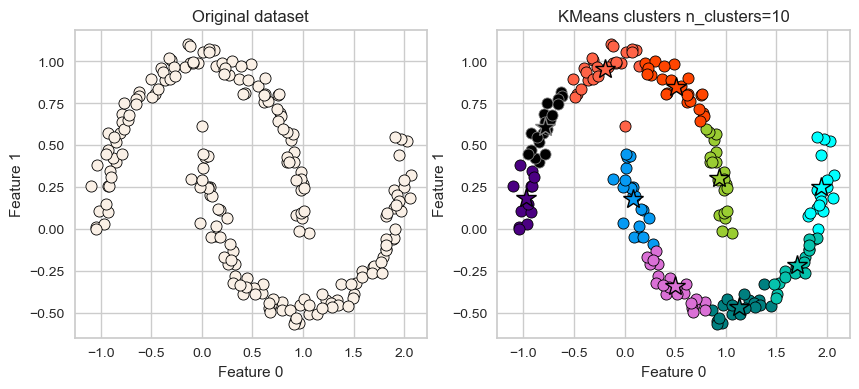

In [3]:
plot_kmeans(X, 10)

### K-Means: failure case 2 

- Again, K-Means is unable to capture complex cluster shapes. 

In [4]:
X = datasets.make_circles(n_samples=200, noise=0.06, factor=0.4)[0]

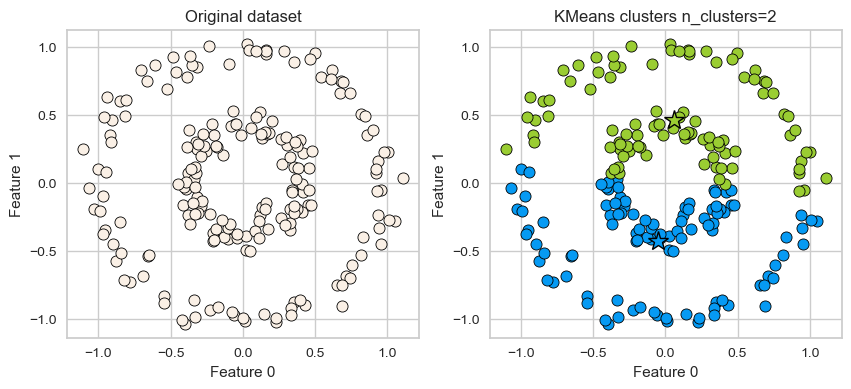

In [5]:
plot_kmeans(X, 2)

### K-Means: failure case 3

- It assumes that all directions are equally important for each cluster and fails to identify non-spherical clusters. 

In [6]:
# generate some random cluster data
X, y = make_blobs(random_state=170, n_samples=200)
rng = np.random.RandomState(74)
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)

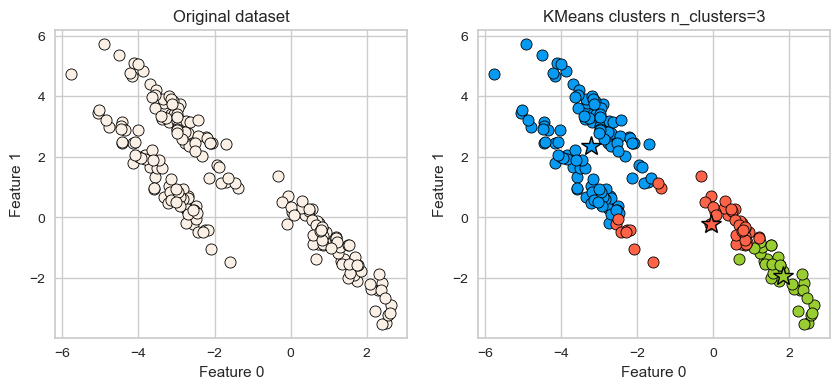

In [7]:
plot_kmeans(X, 3)

- Can we do better than this? 
- Another clustering algorithm called DBSCAN is able to tackle some of these cases. 

<br><br><br><br><br><br>

## DBSCAN [[video](https://youtu.be/T4NLsrUaRtg)]

- **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise

### DBSCAN introduction

- DBSCAN is a density-based clustering algorithm. 
- Intuitively, it's based on the idea that clusters form dense regions in the data and so it works by identifying "crowded" regions in the feature space. 
- It can address some of the limitations of K-Means we saw above. 
    - It does not require the user to specify the number of clusters in advance. 
    - It can identify points that are not part of any clusters. 
    - It can capture clusters of complex shapes. 

Let's try `sklearn`'s DBSCAN.   

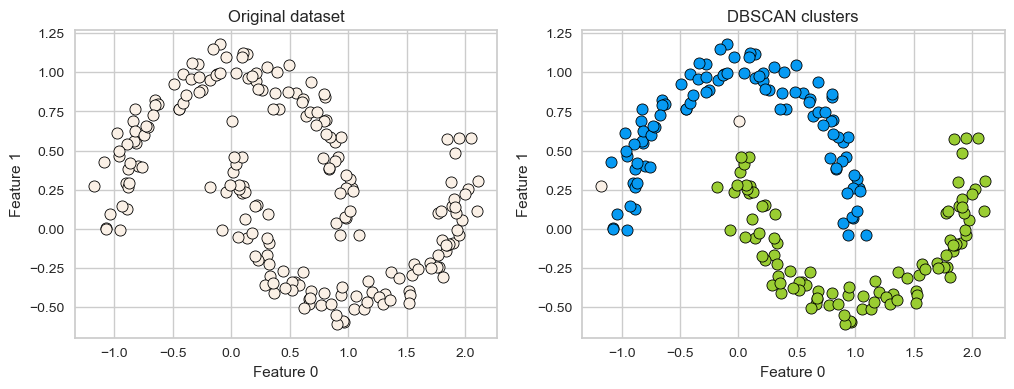

In [8]:
X, y = make_moons(n_samples=200, noise=0.08, random_state=42)
dbscan = DBSCAN(eps=0.2)
dbscan.fit(X)
plot_original_clustered(X, dbscan, dbscan.labels_)

- DBSCAN is able to capture half moons shape
- We don't not have to specify the number of clusters. 
    - That said, it has two other non-trivial hyperparameters to tune. 
- There are two examples which have not been assigned any label (noise examples). 

One more example of DBSCAN clusters capturing complex cluster shapes. 

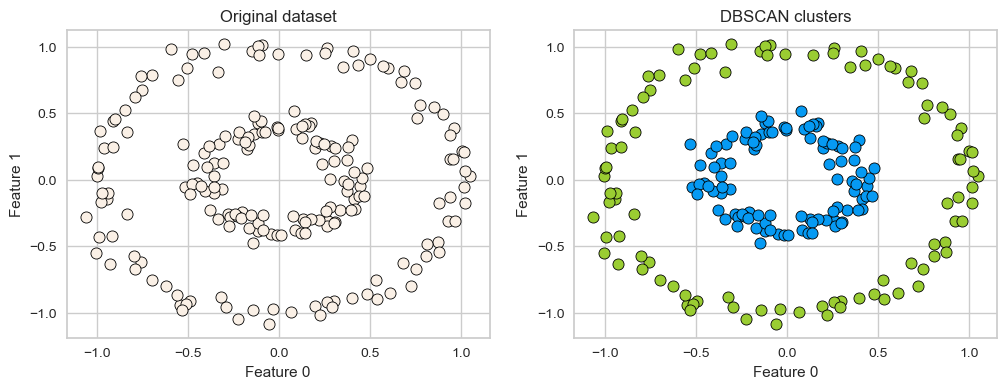

In [9]:
X = datasets.make_circles(n_samples=200, noise=0.06, factor=0.4)[0]
dbscan = DBSCAN(eps=0.3, min_samples=3)
dbscan.fit(X)
plot_original_clustered(X, dbscan, dbscan.labels_)

### How does it work?

- Iterative algorithm.  
- Based on the idea that clusters form dense regions in the data. 

![](../img/DBSCAN_search.gif)

<!-- <center>
<img src="img/DBSCAN_search.gif" alt="" height="900" width="900"> 
</center>
 -->
[Source](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)

There are three kinds of points.

- **Core points** are the points that have at least `min_samples` points within a distance of `eps` (including itself)

- **Border points** are connected to a core point. They are within a distance of `eps` to at least one core point but they have fewer than `min_samples` points within a distance of `eps`. 

- **Noise points** are the points which do not belong to any cluster. In other words, the points which have less than `min_samples` points within distance `eps` of the starting point are noise points. 


**DBSCAN algorithm**

- Pick a point $p$ at random.

- Check whether $p$ is a "core" point or not. You can check this by looking at the number of points within epsilon distance, and count if there are at least `min_samples` points in that neighbourhood
- If $p$ is a core point, give it a colour (label). 
- Spread the colour of $p$ to all of its neighbours (with distance `eps`).
- Check if any of the neighbours that received the colour is a core point, if yes, spread the colour to its neighbors as well.
- Once there are no more core points left to spread the colour, pick a new unlabeled point $p$ and repeat the process.

**DBSCAN Analogy**

Consider DBSCAN in a social context: 
- Social butterflies (🦋): Core points
- Friends of social butterflies who are not social butterflies: Border points
- Lone wolves (🐺): Noise points  


**Two main hyperparameters**
- `eps`: determines what it means for points to be "close"
- `min_samples`: determines the number of **neighboring points** we require to consider in order for a point to be part of a cluster

**Effect of `eps` hyperparameter**

In [46]:
X, y = make_blobs(random_state=40, centers=2, n_samples=6)

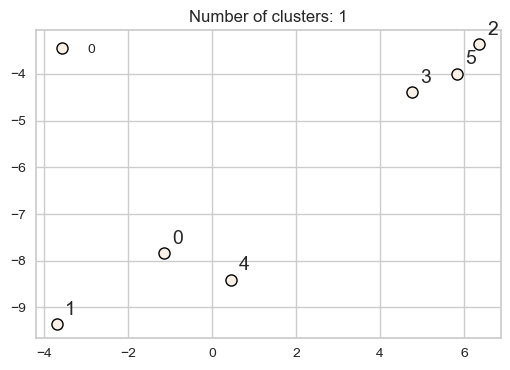

In [50]:
import panel as pn
from panel import widgets
from panel.interact import interact
import matplotlib

pn.extension()

def f(eps):
    fig = plt.figure(figsize=(6, 4))
    return plot_dbscan_with_labels(X, fig, eps, min_samples=3)

f(8)

In [12]:
dists = euclidean_distances(X, X)
pd.DataFrame(dists).round(2)

,0,1,2,3,4,5
0,0.00,2.97,8.73,6.83,1.68,7.95
1,2.97,0.00,11.70,9.80,4.25,10.92
2,8.73,11.70,0.00,1.90,7.77,0.82
3,6.83,9.80,1.90,0.00,5.89,1.14
4,1.68,4.25,7.77,5.89,0.00,6.95
5,7.95,10.92,0.82,1.14,6.95,0.00


In [13]:
dists.min(), dists.max(), dists.mean()

(np.float64(0.0),
 np.float64(11.699901396097971),
 np.float64(4.961109802000134))

**Effect of `min_samples` hyperparameter**

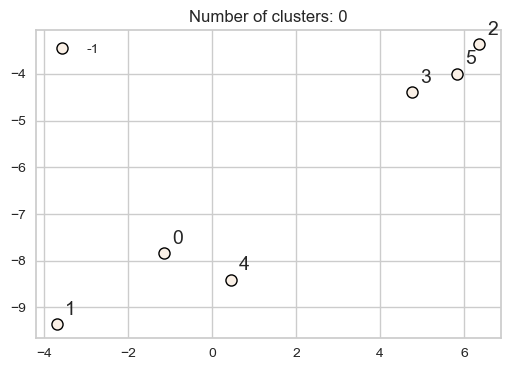

In [53]:
def f(min_samples):
    fig = plt.figure(figsize=(6, 4))
    return plot_dbscan_with_labels(X, fig, eps=2.0, min_samples=min_samples)

f(4)

### More details on DBSCAN

**Illustration of hyperparameters `eps` and `min_samples`**

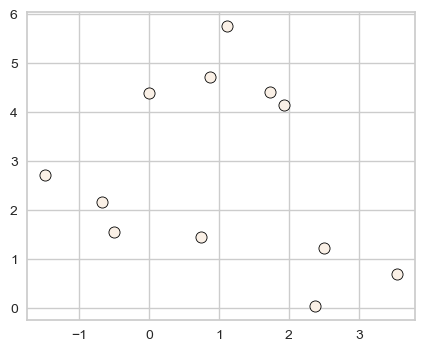

In [15]:
X, y = make_blobs(random_state=0, n_samples=12)
discrete_scatter(X[:, 0], X[:, 1]);

In [16]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
print("Cluster memberships:{}".format(clusters))

Cluster memberships:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


- Default values for hyperparameters don't work well on toy datasets. 
- All points have been marked as noise with the default values for `eps` and `min_samples`
- Let's examine the effect of changing these hyperparameters. 
    - noise points: shown in white
    - core points: bigger
    - border points: smaller

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


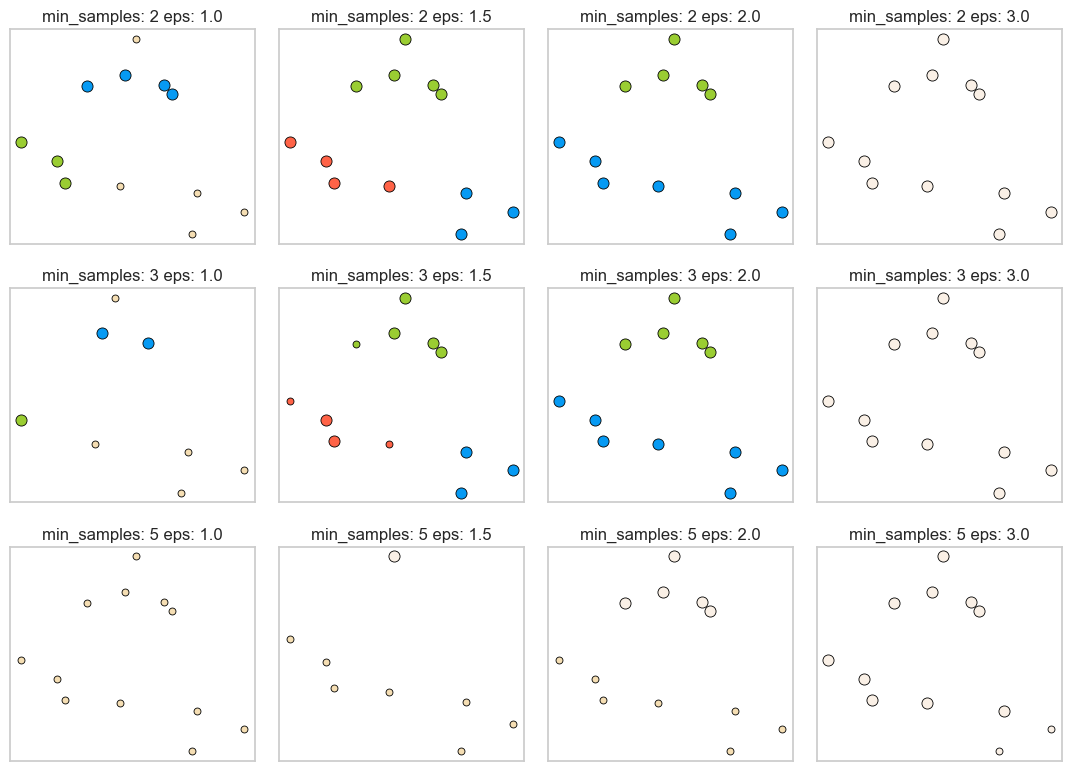

In [17]:
plot_dbscan()

**Observations**

- Increasing `eps` ($\uparrow$) (left to right in the plot above) means more points will be included in a cluster. 
    - `eps` = 1.0 either creates more clusters or more noise points, whereas eps=3.0 puts all points in one cluster with no noise points.  
- Increasing `min_samples` ($\uparrow$) (top to bottom in the plot above) means points in less dense regions will either be labeled as their own cluster or noise. 
    - `min_samples=2`, for instance, has none or only a fewer noise points whereas `min_samples=5` has several noise points. 
- Here `min_samples` = 2.0 or 3.0 and `eps` = 1.5 is giving us the best results. 
- In general, it's not trivial to tune these hyperparameters. 


**K-Means vs. DBSCAN**

- In DBSCAN, you do not have to specify the number of clusters! 
    - Instead, you have to tune `eps` and `min_samples`. 
- Unlike K-Means, DBSCAN doesn't have to assign all points to clusters. 
    - The label is -1 if a point is unassigned.
- Unlike K-Means, there is no `predict` method. 
    - DBSCAN only really clusters the points you have, not "new" or "test" points.

### Question for you

- Does the order that you pick the points matter in DBSCAN?
<br><br><br><br>

> No. Any of the cluster's core points is able to fully identify the cluster, with no randomness involved. The only possible conflict you might get is that if two clusters have the same border point. In this case the assignment will be implementation dependent, but usually the border point will be assigned to the first cluster that "finds" it. 

### Evaluating DBSCAN clusters 
- We cannot use the elbow method to examine the goodness of clusters created with DBSCAN. 
- But we can use the silhouette method because it's not dependent on the idea of cluster centers. 

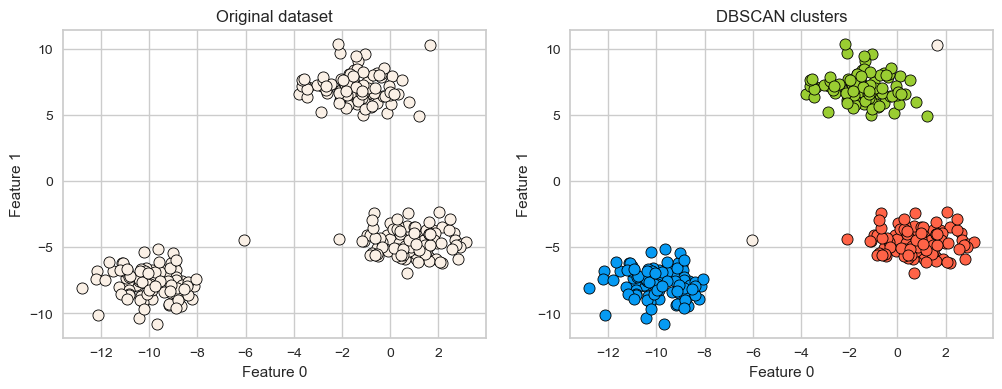

In [18]:
X, y = make_blobs(random_state=100, centers=3, n_samples=300)
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan.fit(X)
plot_original_clustered(X, dbscan, dbscan.labels_)

In [19]:
# Yellowbrick is designed to work with K-Means and not with DBSCAN.
# So it needs the number of clusters stored in n_clusters
# It also needs `predict` method to be implemented.
# So I'm implementing it here so that we can use Yellowbrick to show Silhouette plots.
n_clusters = len(set(dbscan.labels_))
dbscan.n_clusters = n_clusters
dbscan.predict = lambda x: dbscan.labels_

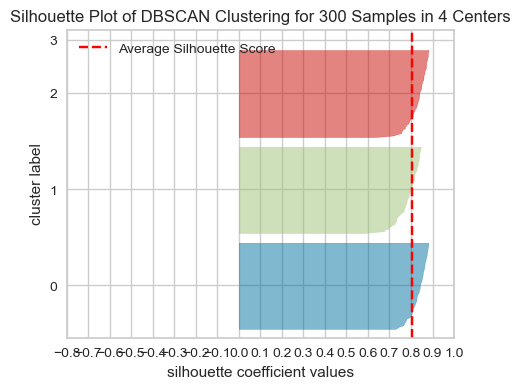

In [20]:
visualizer = SilhouetteVisualizer(dbscan, colors="yellowbrick")
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show();

### Summary: Pros and cons

- Pros
    - Can learn arbitrary cluster shapes
    - Can detect outliers 
- Cons
    - Cannot `predict` on new examples.  
    - Needs tuning of two non-obvious hyperparameters 

There is an improved version of DBSCAN called [`HDBSCAN` (hierarchical DBSCAN)](https://github.com/scikit-learn-contrib/hdbscan). 

### DBSCAN: failure cases

- DBSCAN is able to capture complex clusters. But this doesn't mean that `DBSCAN` always works better. It has its own problems! 
- DBSCAN doesn't do well when we have clusters with different densities. 
    - You can play with the hyperparameters but it's not likely to help much.

### DBSCAN: failure cases

- Let's consider this dataset with three clusters of varying densities.  
- K-Means performs better compared to DBSCAN. But it has the benefit of knowing the value of $K$ in advance. 


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


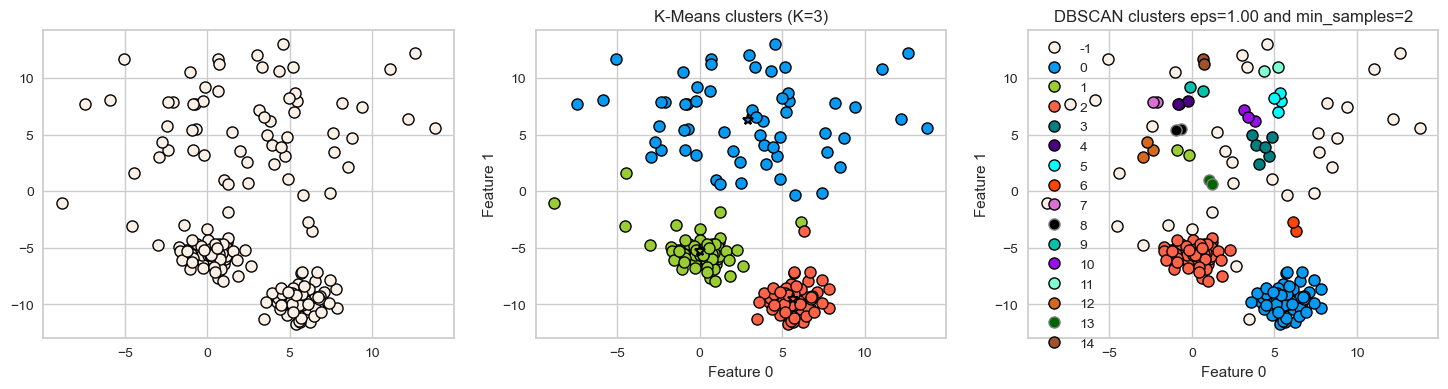

In [21]:
X_varied, y_varied = make_blobs(
    n_samples=200, cluster_std=[1.0, 5.0, 1.0], random_state=10
)
plot_k_means_dbscan_comparison(X_varied)

## ❓❓ Questions for you

### 16.2 Select all of the following statements which are **True** https://join.iclicker.com/FUYI

- (A) With tiny epsilon (`eps` in `sklearn`) and min samples=1 (`min_samples=1` in `sklearn`) we are likely to end up with each point in its own cluster. 
- (B) With a smaller value of `eps` and larger number for `min_samples` we are likely to end up with a one big cluster. 
- (C) K-Means is more susceptible to outliers compared to DBSCAN.  
- (D) In DBSCAN to be part of a cluster, each point must have at least `min_samples` neighbours in a given radius (including itself). 

<br><br><br><br>

## Hierarchical clustering [[video](https://www.youtube.com/watch?v=NM8lFKFZ2IU)]

### Introduction 
- Deciding how many clusters we want is a hard problem. 
- Often, it's useful to get a complete picture of similarity between points in our data before picking the number of clusters.  
- Hierarchical clustering is helpful in these scenarios.  

**Main idea**

1. Start with each point in its own cluster. 
2. Greedily merge most similar *clusters*. 
3. Repeat Step 2 until you obtain only one cluster ($n-1$ times).

- Hierarchical clustering can be visualized using a tool called **a dendrogram**. 
- Unfortunately, `sklearn` cannot do it so we will use the package `scipy.cluster.hierarchy` for hierarchical clustering. Let's try it out before understanding how it works. 

In [22]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

X_orig, y = make_blobs(random_state=0, n_samples=11)
X = StandardScaler().fit_transform(X_orig)
linkage_array = ward(X)

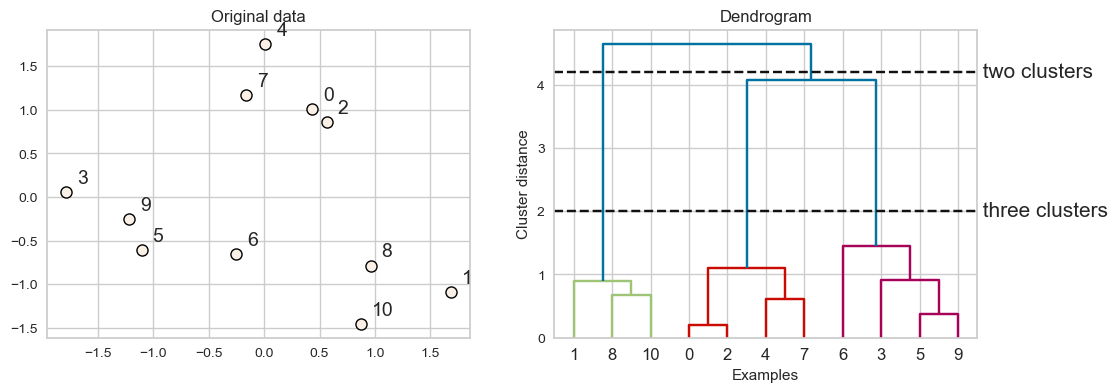

In [23]:
plot_X_dendrogram(X, linkage_array, label_n_clusters=True) # user-defined function defined in code/plotting_functions.py

- Every point goes through the journey of being on its own (its own cluster) and getting merged with some other bigger clusters. 
- The intermediate steps in the process provide us clustering with different number of clusters. 

### Dendrogram

- Dendrogram is a tree-like plot. 
- On the x-axis we have data points. 
- On the y-axis we have distances between clusters. 
- We start with data points as leaves of the tree.  
- New parent node is created for every two clusters that are joined. 
- The length of each branch shows how far the merged clusters go. 
    - In the dendrogram above going from three clusters to two clusters means merging far apart points because the branches between three cluster to two clusters are long. 

**How to plot a dendrogram?**

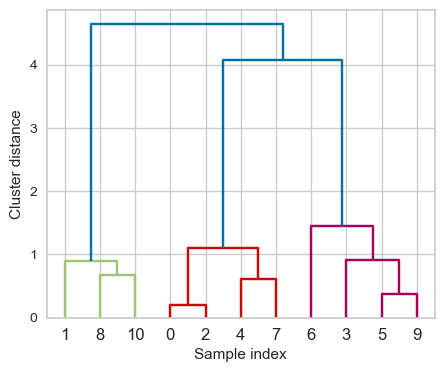

In [24]:
from scipy.cluster.hierarchy import dendrogram

ax = plt.gca()
dendrogram(linkage_array, ax=ax, color_threshold=3)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance");

```{note} 
The colours you see above are based on the `color_threshold` parameter. It colours all the descendent links below a cluster node $k$ the same color if $k$ is the first node below the cut threshold.

**Flat clusters**

- This is good but how can we get cluster labels from a dendrogram? 
- We can bring the clustering to a "flat" format using `fcluster`

In [25]:
from scipy.cluster.hierarchy import fcluster

# flattening the dendrogram based on maximum number of clusters. 
hier_labels1 = fcluster(linkage_array, 3, criterion="maxclust") 
hier_labels1

array([2, 1, 2, 3, 2, 3, 3, 2, 1, 3, 1], dtype=int32)

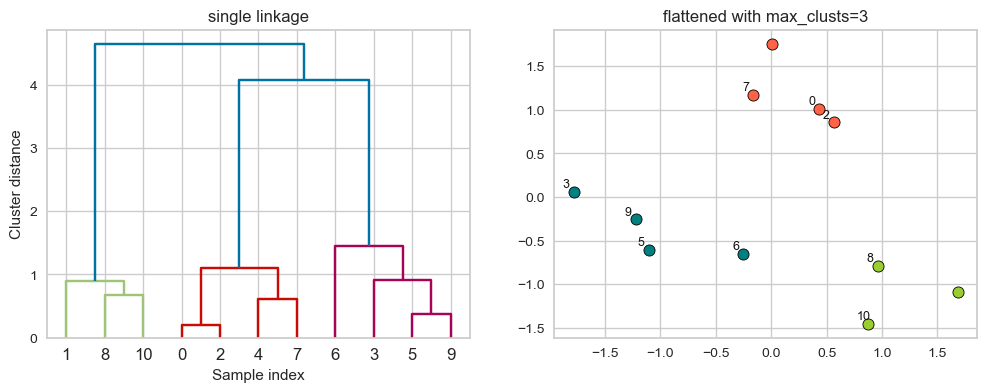

In [26]:
plot_dendrogram_clusters(X, linkage_array, hier_labels1, title="flattened with max_clusts=3")

In [27]:
# flattening the dendrogram based on maximum distance between points. 
hier_labels2 = fcluster(linkage_array, 0.7, criterion="distance") 
hier_labels2

array([3, 2, 3, 6, 4, 5, 7, 4, 1, 5, 1], dtype=int32)

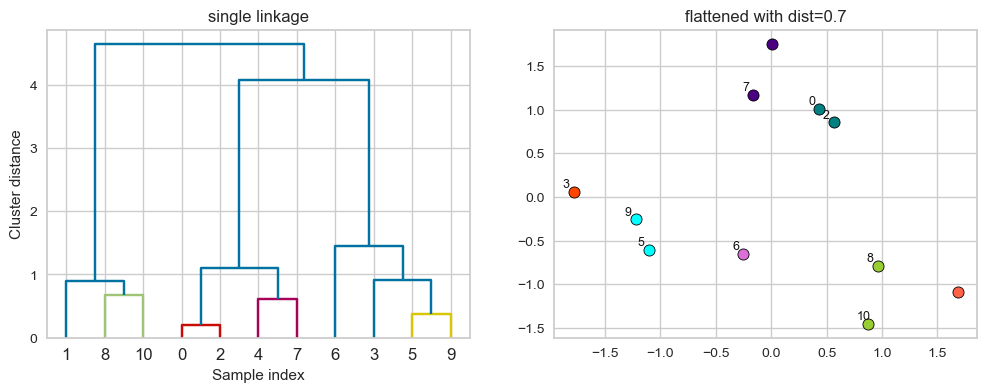

In [28]:
plot_dendrogram_clusters(X, linkage_array, hier_labels2, title="flattened with dist=0.7", color_threshold=0.7)

When we create a dendrogram, we need to calculate distance between clusters. 

- We know how to measure distance between points (e.g., using Euclidean distance). 
- How do we measure distances between clusters? 
- The **linkage criteria** determines how to find similarity between clusters:
- Some example linkage criteria are: 
    - Single linkage $\rightarrow$ smallest minimal distance, leads to loose clusters
    - Complete linkage $\rightarrow$ smallest maximum distance, leads to tight clusters 
    - Average linkage $\rightarrow$ smallest average distance between all pairs of points in the clusters
    - Ward linkage $\rightarrow$ smallest increase in within-cluster variance, leads to equally sized clusters

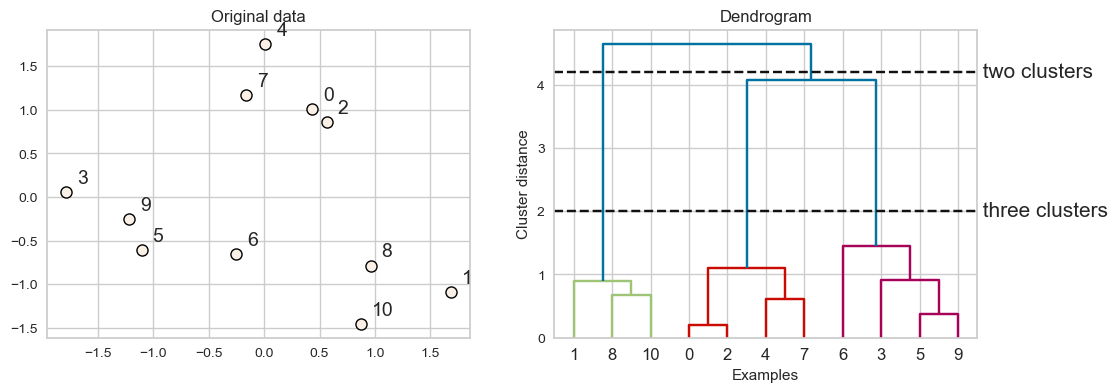

In [29]:
plot_X_dendrogram(X, linkage_array, label_n_clusters=True)

**`single` linkage**

- Merges two clusters that have the smallest minimum distance between all their points. 
- Let's use `scipy.cluster.hierarchy`'s `single` to get linkage information. 
- This method gives us matrix `Z` with the merging information. 

In [30]:
Z = single(X)
columns = ["c1", "c2", "distance(c1, c2)", "# observations"]

In [31]:
pd.DataFrame(Z, columns=columns).head()

,c1,c2,"distance(c1, c2)",# observations
0,0.0,2.0,0.201332,2.0
1,5.0,9.0,0.368922,2.0
2,4.0,7.0,0.610931,2.0
3,11.0,13.0,0.617431,4.0
4,3.0,12.0,0.644770,3.0


- The linkage returns a matrix `Z` of shape n-1 by 4:
- The rows represent iterations. 
- First and second columns (c1 and c2 above): indexes of the clusters being merged.
- Third column (distance(c1, c2)): the distance between the clusters being merged.
- Fourth column (# observations): the number of examples in the newly formed cluster.

**Creating dendrogram with `single` linkage**

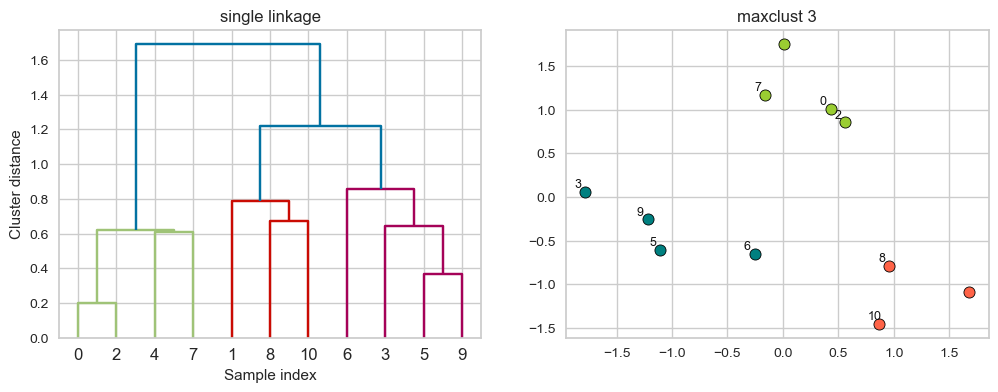

In [32]:
linkage_array = single(X)
hier_labels = fcluster(linkage_array, 3, criterion="maxclust") 
plot_dendrogram_clusters(X, linkage_array, hier_labels, title="maxclust 3", color_threshold=1.0)

Suppose we decide to go from 3 clusters to 2 clusters. Which clusters would be merged with single linkage criterion? It will merge the clusters with the smallest minimal distance. 

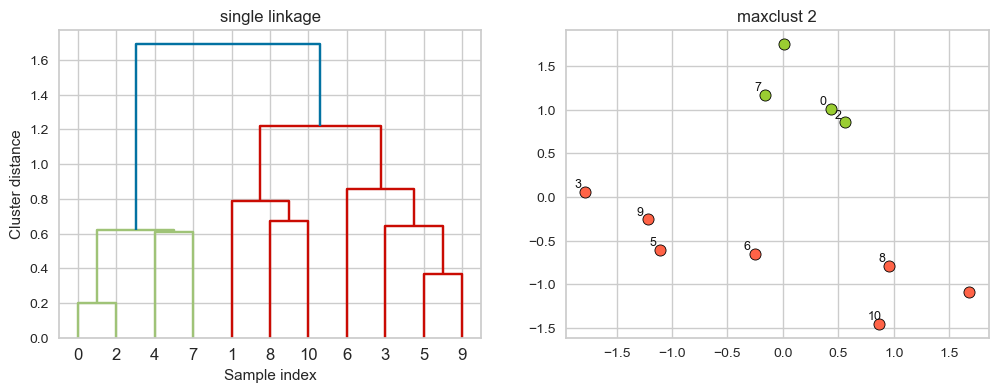

In [33]:
hier_labels = fcluster(linkage_array, 2, criterion="maxclust") 
plot_dendrogram_clusters(X, linkage_array, hier_labels,title="maxclust 2", color_threshold=1.4)

**`complete` linkage**

- Merges two clusters that have the smallest maximum distance between their points. 

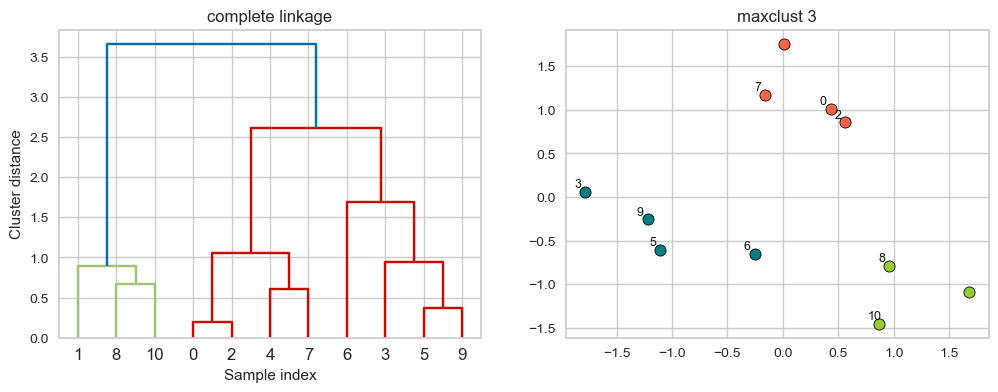

In [34]:
linkage_array = complete(X)
hier_labels = fcluster(linkage_array, 3, criterion="maxclust") 
plot_dendrogram_clusters(X, linkage_array, hier_labels, linkage_type='complete', title="maxclust 3")

Suppose we decide to go from 3 clusters to 2 clusters. Which clusters would be merged with single linkage criterion? It will merge the clusters with the smallest maximum distance. 

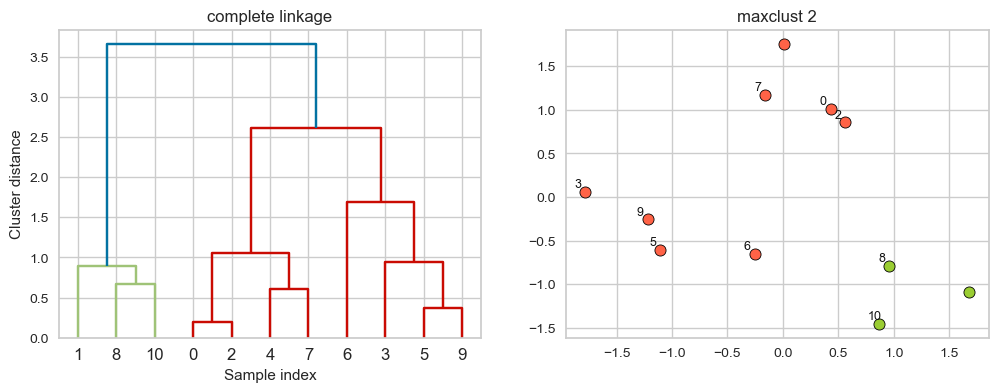

In [35]:
hier_labels = fcluster(linkage_array, 2, criterion="maxclust") 
plot_dendrogram_clusters(X, linkage_array, hier_labels, linkage_type='complete', title="maxclust 2")

**`average` linkage**

- Merges two clusters that have the smallest average distance between all their points. 

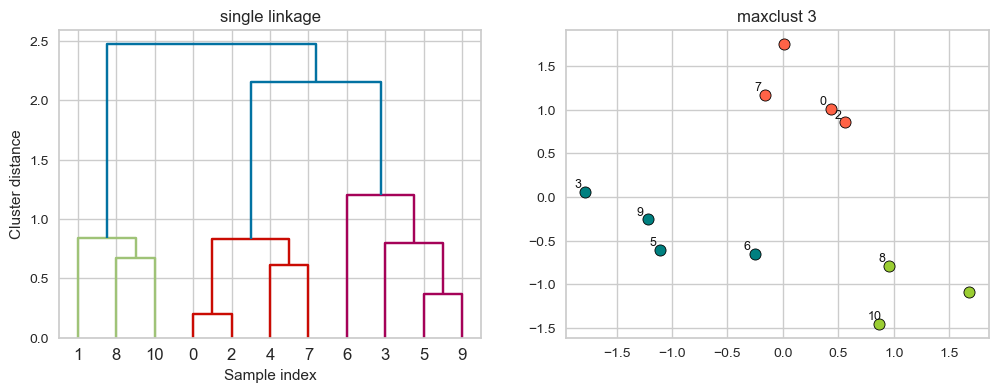

In [36]:
linkage_array = average(X)
hier_labels = fcluster(linkage_array, 3, criterion="maxclust") 
plot_dendrogram_clusters(X, linkage_array, hier_labels, title="maxclust 3", color_threshold=1.5)

Suppose we decide to go from 3 clusters to 2 clusters. Which clusters would be merged with single linkage criterion? It will merge the clusters with the smallest average distance. 

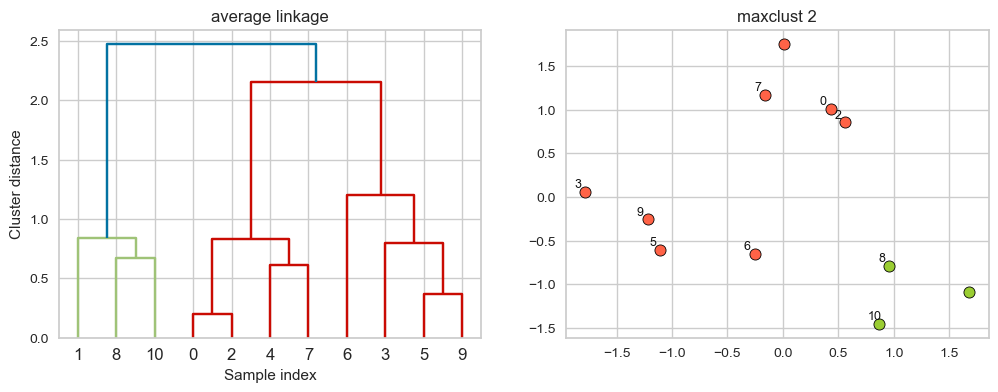

In [37]:
hier_labels = fcluster(linkage_array, 2, criterion="maxclust") 
plot_dendrogram_clusters(X, linkage_array, hier_labels, linkage_type='average', title="maxclust 2", color_threshold=2.25)

**`ward` linkage**

- Picks two clusters to merge such that the variance within all clusters increases the least. 
- Often leads to equally sized clusters. 

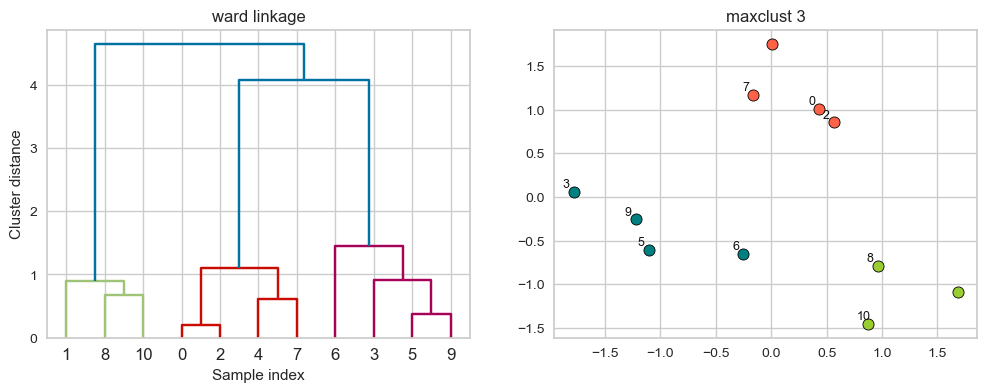

In [38]:
linkage_array = ward(X)
hier_labels = fcluster(linkage_array, 3, criterion="maxclust") 
plot_dendrogram_clusters(X, linkage_array, hier_labels, linkage_type='ward', title="maxclust 3")

Suppose we decide to go from 3 clusters to 2 clusters. Which clusters would be merged with ward linkage criterion? It will merge the clusters with the smallest within-cluster variance. 

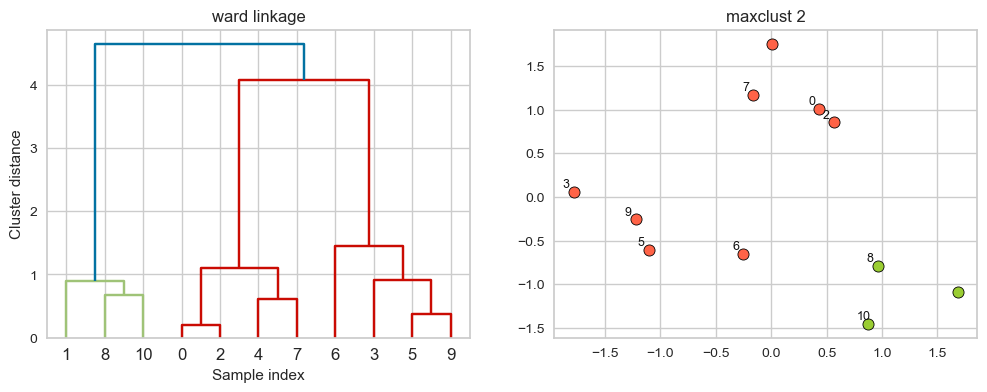

In [39]:
hier_labels = fcluster(linkage_array, 2, criterion="maxclust") 
plot_dendrogram_clusters(X, linkage_array, hier_labels, linkage_type='ward', title="maxclust 2", color_threshold=4.3)

Different type of linkage criterion can be appropriate in different scenarios and the goals of clustering analysis. 

In [40]:
from sklearn.datasets import make_blobs
X2, y = make_blobs(n_samples=200, centers=3, random_state=0)
np.random.seed(42)
X2[:50] += np.random.uniform(low=0.3, high=1, size=(50, 2)) # Add some noise to the dataset

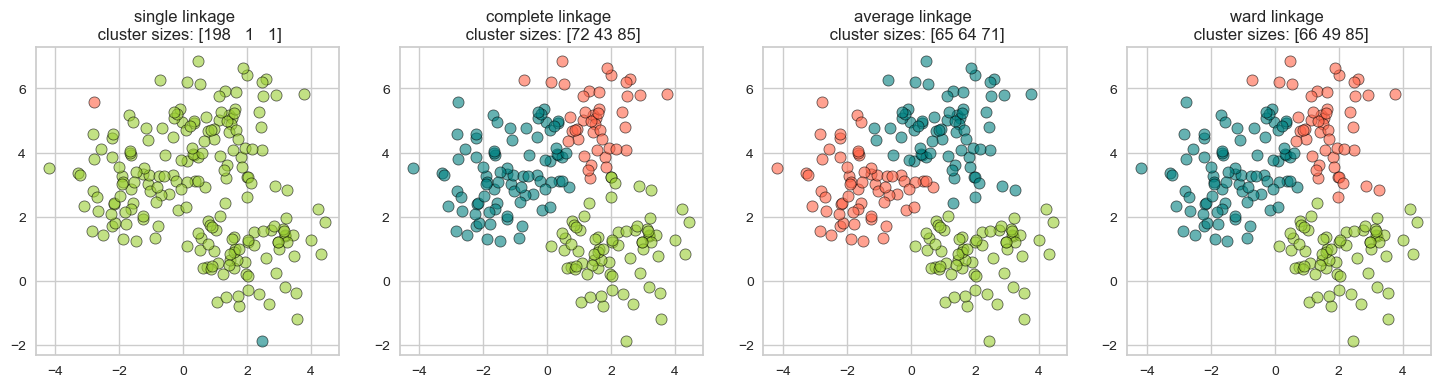

In [41]:
plot_linkage_criteria(X2, 3)

- Single linkage $\rightarrow$ smallest minimal distance, leads to loose clusters
- Complete linkage $\rightarrow$ smallest maximum distance, leads to tight clusters 
- Average linkage $\rightarrow$ smallest average distance between all pairs of points in the clusters
- Ward linkage $\rightarrow$ smallest increase in within-cluster variance, leads to equally sized clusters

**Truncation**

This is a toy dataset and it's possible to view all the leaves. But what if we have thousands of examples, which is common in real-world datasets? We can use truncation. There are two levels of truncation supported in `scipy.cluster.hierarchy`. 
- `level` $\rightarrow$ Maximum depth of the tree is $p$
- `lastp` $\rightarrow$ Only $p$ leaves are shown 

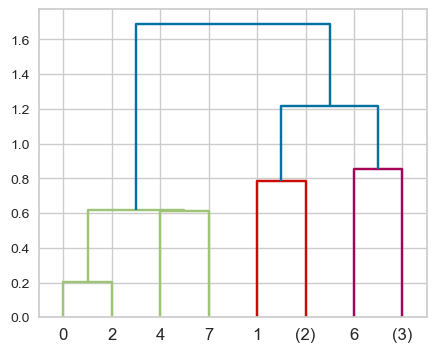

In [42]:
Z = single(X)
dendrogram(Z, p=2, truncate_mode="level");
# p is the max depth of the tree

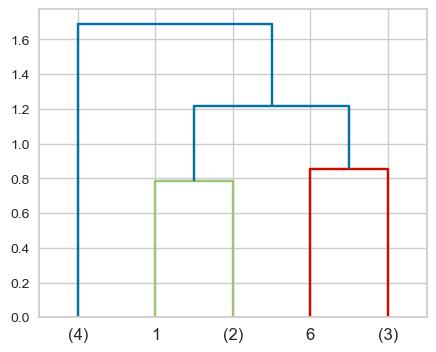

In [43]:
dendrogram(Z, p=5, truncate_mode="lastp");
# p is the number of leaf nodes

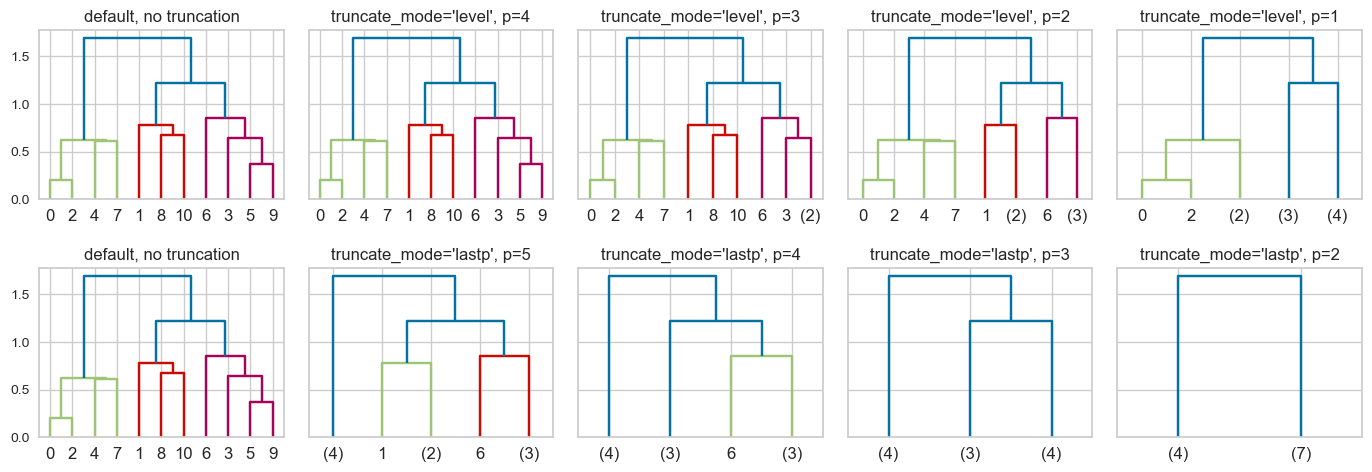

In [44]:
hc_truncation_toy_demo(Z);

```note
I’m not quite sure why we see 0 and 2 not merged for truncation_mode = 'level' and p=1 🤔.
```

<br><br>

<br><br>

## ❓❓ Questions for you https://join.iclicker.com/FUYI

### 16.3 Select all of the following statements which are **True** 

- (A) In hierarchical clustering we do not have to worry about initialization. 
- (B) Hierarchical clustering can only be applied to smaller datasets because dendrograms are hard to visualize for large datasets.
- (C) In all the clustering methods we have seen (K-Means, DBSCAN, hierarchical clustering), there is a way to decide the granularity of clustering (i.e., how many clusters to pick). 
- (D) To get robust clustering we can naively ensemble cluster labels (e.g., pick the most popular label) produced by different clustering methods. 
- (E) If you have a high Silhouette score and very clean and robust clusters, it means that the algorithm has captured the semantic meaning in the data of our interest.   

<br><br><br><br>

## Final comments, summary, and reflection

### Take-home message

- We saw four methods for clustering: Centroid-based clustering (K-Means), distribution-based clustering (Gaussian mixture models), density-based clustering (DBSCAN), and hierarchical clustering. 
- There are many more clustering algorithms out there which we didn't talk about. For example see [this overview of clustering methods](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods). 
- Two important aspects of clustering
    - Choice of distance metric
    - Data representation
- Choosing the appropriate number of clusters for a given problem is quite hard. 
- A lot of manual interpretation is involved in clustering. 

### A few comments on clustering evaluation

- If you know the ground truth, you can use metrics such as [adjusted random score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) or [normalized mutual information score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html). 
- We can't use accuracy scores. 
    - Because the labels themselves are meaningless in clustering.  
- Usually ground truth is not available, and if it is available we would probably go with supervised models.     


- The silhouette score works for different clustering methods and it can give us some intuition about the quality of clusters. But it's not very interpretable on real-world datasets.

A couple of ways to evaluate clustering: 
- Using *robustness-based* clustering metrics
- The idea is to run a clustering algorithm or a number of clustering algorithms after adding some noise to the data or using different parameter settings and comparing outcomes. 
- If many models, perturbations, and parameters are giving the same result, the clustering is likely to be trustworthy.  
- But how do we compare clustering partitions of two different clustering models? We can use some metrics which are based on the [contingency matrix](http://www.comparingpartitions.info/?link=Tut14).  
- That said, even though all clustering models give similar results, the clusters might not capture the aspect you are interested in. 
- So you cannot really avoid manual inspection. 
- Manual inspection and analysis is tedious but remember that this is what makes data scientists valuable. We can focus on the things ML models are not good at. 

<br><br>

## Resources 

- Check out this nice comparison of [sklearn clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods).
- [DBSCAN Visualization](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
- There is also [Hierarchical DBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html). 
- [Clustering with Scikit with GIFs](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)